In [2]:
import numpy as np
import pandas as pd
from gurobipy import *

# For progress bar
# Instead of writing...
# > for i in some_list:
# You can write....
# > for i in tqdm(some_list):
# And you will get a very nice progress bar. This is very nice for 
# for-loops that run a long time, like running an optimization model for 
# many timesteps :)
from tqdm.auto import tqdm, trange  

# Plotting libaries - Feel free to use any others of your choice
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('fivethirtyeight')

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# HINT  
I recommend that you read through this notebook once *before* you start coding - you can do it all on your own but if you adhere to the structure that we hint at in this notebook, it might be easier for you

## Reading data  
This data is pretty clean but there are some surprises... I recommend that you re-index the dataframe with a [datetime-index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) since they have some very convienient attributes and methods which you will need (unless you want to put more effort into this).  
So for example the entries "01-01-2019", "00 - 01" should be changed so that this row has a datetime index "2019-01-01 00:00:00"

In [321]:
def read_ElspotPrices(filename):
    # TODO
    df = pd.concat(pd.read_html(filename, header = 2, decimal = ',')) #liest Daten und macht Spalten [0,1] zu individuellen Datenindizes
    df.rename(columns={'Unnamed: 0':'Day'}, inplace = True)
    df['Dateindex'] = None
    space = " "
    for index, row in df.iterrows():
        df.at[index,'Dateindex'] = pd.to_datetime(space.join([str(df['Day'][index]), str(df['Hours'][index]).split()[0]]), format = "%d-%m-%Y %H")
    df.set_index('Dateindex', inplace = True)
    df.drop(columns=['Day', 'Hours'], inplace = True)
    return df # Returning a pandas dataframe

In [322]:
path = "elspot-prices_2019_hourly_eur.xls"
df = read_ElspotPrices(path) # You can rename variables
#space = " "
#print(pd.to_datetime(space.join([str(df['Day'][0]), str(df['Hours'][0]).split()[0]]), format = "%d-%m-%Y %H"))
print(df)
#print(df.info())


SYS     SE1     SE2     SE3     SE4      FI     DK1  \
Dateindex                                                                     
2019-01-01 00:00:00  4455.0  2832.0  2832.0  2832.0  2832.0  2832.0  2832.0   
2019-01-01 01:00:00  4407.0  1007.0  1007.0  1007.0  1007.0  1007.0  1007.0   
2019-01-01 02:00:00  4112.0  1003.0  1003.0  1003.0  1003.0  1003.0  -408.0   
2019-01-01 03:00:00  3888.0   456.0   456.0   456.0   456.0   456.0  -991.0   
2019-01-01 04:00:00  3570.0   483.0   483.0   483.0   483.0   483.0  -741.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2019-12-31 19:00:00  3330.0  3237.0  3237.0  3237.0  3237.0  3237.0  3385.0   
2019-12-31 20:00:00  3230.0  3123.0  3123.0  3123.0  3123.0  3123.0  3354.0   
2019-12-31 21:00:00  3217.0  3133.0  3133.0  3133.0  3133.0  3133.0  3317.0   
2019-12-31 22:00:00  3208.0  3146.0  3146.0  3146.0  3146.0  3146.0  3304.0   
2019-12-31 23:00:00  3152.0  3083.0  3083.0  3083.0  3083.0  3083.0  3228.0 

#### Daylight savings time  
The data from Elspot contains one hour twice and one hour is missing, thanks to daylight savings time. You have to convert the data so that the timezone is without daylight savings (so no hours exist twice or are missing).
You should also convert the data to UTC+0. The Nordpool headquarters are in norway (CET with summer time, so during the summer they have UTC+2 and during winter UTC+1). 
Below an example of the day light savings switch and how it should look like after you converted the time.  
Hint: You can use pandas functions for this, it can be done in three lines of code 

In [188]:
# Find the day light savings switch with duplicated datetime (clocks turned back for 1 hour)
# You can remove this cell if you want
#timediffs = pd.Series(df.index).diff() # Calculate time difference between indices
#daylight_idx = timediffs[timediffs == pd.Timedelta(0)].idxmax() #  Find row with no time-difference
#print(df.iloc[daylight_idx])
#df[daylight_idx:daylight_idx+1].index
#print(df[daylight_idx-2:daylight_idx+2].index) # Show the rows surrounding this row
#print(df[df.isnull().all(axis = 1)].index)
#print(df.isnull().all(axis = 1))
#print(~df.isna().any(axis = 1))

In [5]:
def removeDaylightSavings(df):
    #find index of first shift: from normal- to summertime (row with no timediff to previous row)
    index1 = df.index.get_loc(df[df.isnull().all(axis = 1)].index.item())
    #find index of second shift: from summer- bach to normaltime
    timediffs = pd.Series(df.index).diff() # Calculate time difference between indices
    index2 = timediffs[timediffs == pd.Timedelta(0)].idxmax() #  Find row with no time-difference
    #shift Data from [index1+1:index2] 1 hour into the past and delete the row with the double index
    df[index1:index2+1] = df[index1:index2+1].shift(periods = -1)
    df.dropna(how = 'all', inplace = True)
    #shift time-index to UTC+0 
    df = df.shift(periods = -1, freq = 'h')
    return df

In [6]:
df = removeDaylightSavings(df)
df.info()
#df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 23:00:00 to 2019-12-31 22:00:00
Freq: H
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SYS      8760 non-null   float64
 1   SE1      8760 non-null   float64
 2   SE2      8760 non-null   float64
 3   SE3      8760 non-null   float64
 4   SE4      8760 non-null   float64
 5   FI       8760 non-null   float64
 6   DK1      8760 non-null   float64
 7   DK2      8760 non-null   float64
 8   Oslo     8760 non-null   float64
 9   Kr.sand  8760 non-null   float64
 10  Bergen   8760 non-null   float64
 11  Molde    8760 non-null   float64
 12  Tr.heim  8760 non-null   float64
 13  TromsÃ¸  8760 non-null   float64
 14  EE       8760 non-null   float64
 15  LV       8760 non-null   float64
 16  LT       8760 non-null   float64
 17  AT       4345 non-null   float64
 18  BE       4345 non-null   float64
 19  DE-LU    4345 non-null   float64
 20  FR      

In [191]:
# Show results
#df[daylight_idx-2:daylight_idx+2]

This is how your data should be formated that you use as input for the "prediction generator":  
* pd.Series() containing the prices for your market area
* index should be of type datetime -> This will make it much easier to create your plots later

In [7]:
example = df["SE1"]
example

Dateindex
2018-12-31 23:00:00    2832.0
2019-01-01 00:00:00    1007.0
2019-01-01 01:00:00    1003.0
2019-01-01 02:00:00     456.0
2019-01-01 03:00:00     483.0
                        ...  
2019-12-31 18:00:00    3237.0
2019-12-31 19:00:00    3123.0
2019-12-31 20:00:00    3133.0
2019-12-31 21:00:00    3146.0
2019-12-31 22:00:00    3083.0
Freq: H, Name: SE1, Length: 8760, dtype: float64

In [8]:
df.index

DatetimeIndex(['2018-12-31 23:00:00', '2019-01-01 00:00:00',
               '2019-01-01 01:00:00', '2019-01-01 02:00:00',
               '2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               ...
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Dateindex', length=8760, freq='H')

## "Predicting" future prices  
Since this is not a data science course, we will compare two very simple "prediction" methods:  
1) We perfectly know future prices  
2) Assume price will be the same as last weeks price at the same time  
  
If you want, you can also implement more elaborate prediction methods - you may be able to beat the results from 2) but you should not be able to beat 1)   
In case you implement another predictor, you should obviously only use the prices up to t-1 to predict prices for t to t + n :)

In [9]:
# You do not have to touch this code
class PredictionGenerator():
    def __init__(self, timeseries, method="perfect"):
        self.setMethod(method)
        self.df = timeseries

    # If you use more elaborate prediction methods, you might have to fit a model to the data
    # Implementing another prediction method will not better your grade, so ignore this if you want.
    def fit(self, end_date):
        pass

    # "Predict" prices for some date range defined by a start date and a number of hours
    def predict(self, start_date, nhours):
        dates = pd.date_range(
            start=start_date,
            periods=nhours,
            freq="H")

        if self.method == "Perfect":
            if dates.max() not in self.df.index: # check if prices known
                raise Exception(("You can not forecast the *future* perfectly "
                                 "out of sample! Some of the dates requested "
                                 "are not in the given dataset."))
            result = self.df.loc[dates]  # the actual observed prices
        elif self.method == "SameHourLastWeek":
            min_date = (dates.min() + pd.DateOffset(hours=-7*24))
            max_date = (dates.max() + pd.DateOffset(hours=-7*24))
            if (min_date not in self.df.index) or (max_date not in self.df.index):
                raise Exception(("For some of the dates you tried to predict, "
                                 "there is no data from the week before available."))
            # Last weeks prices
            result = self.df.loc[dates + pd.DateOffset(hours=-7*24)]
            result.index = dates
            
        return result

    
    # Set method if known, otherwise raise exception
    def setMethod(self, method):
        methods = ["Perfect", "SameHourLastWeek"]
        if method not in methods:
            raise Exception(f"Method passed({method}) is not in ["
                            + ", ".join(methods) + "]")
        self.method = method

In [31]:
# Example how to use:
# Create predictor
prediction_method = "SameHourLastWeek" # methods = ["Perfect", "SameHourLastWeek"]
prices = df["SE1"] # All prices that we have for the market area of interest as a Series
predictor = PredictionGenerator(prices, method=prediction_method)
# "Predict" prices for some time frame
t_start = pd.Timestamp("2019-10-22 01:00:00")
predicted_prices = predictor.predict(t_start, 10) # returns a series of "predicted" prices
                                                  # for the 10 hours starting on t_start
predicted_prices

2019-10-22 01:00:00    3384.0
2019-10-22 02:00:00    3413.0
2019-10-22 03:00:00    3518.0
2019-10-22 04:00:00    4061.0
2019-10-22 05:00:00    5264.0
2019-10-22 06:00:00    5521.0
2019-10-22 07:00:00    5480.0
2019-10-22 08:00:00    5176.0
2019-10-22 09:00:00    5062.0
2019-10-22 10:00:00    4790.0
Freq: H, Name: SE1, dtype: float64

## The gurobi model  

In [11]:
def solve(prices,
          Pmax,
          Emax,
          E0,
          print_result=False):
    
    model = Model("Aluminum DSM")
    model.modelSense = GRB.MINIMIZE
    
    # If you test the model for one timestep, you probably want the usual gurobi
    # output, but if you run this model a lot (for every time-step...) this will
    # spam your output window, so i recommend to set print_result=False
    if not print_result:
        model.setParam('OutputFlag', False)
        
    # TODO: Implement model

    T = list(range(len(prices)))

    dP = {}
    dE = {}
    for t in T:
        dP[t] = model.addVar(name = "dP_%s" % (t), lb = -Pmax, ub = Pmax)
        dE[t] = model.addVar(name = "dE_%s" % (t), lb = -Emax, ub = Emax)

    #update the model
    model.update()

    #Energy Balance
    for t in T:
        if t != 0:
            model.addConstr(dE[t-1]+dP[t] == dE[t])
        elif t== 0:
            model.addConstr(dP[t] + E0 == dE[t])

    #neutral energy balance at the end
    for t in T:
        if t == len(T)-1:
            model.addConstr(dE[t] == 0)

    #set objective function and call optimization
    model.setObjective(quicksum(prices[t]*dP[t] for t in T))
    model.optimize()

    return model, dP, dE

# Running your scenario  
The following cell is just to show you how to use tqdm for a progress bar, you can delete that cell and write the code to run the scenario how you want :)

In [124]:
def runScenario(historic_prices,             # Historic electricty prices
                E0, Emax, Pmax,              # Plant parameters
                prediction_method,           # Prediction settings
                t_start, t_end, t_horizon):  # Simulation times

    T = pd.date_range(t_start, t_end, freq="H")
    results = pd.DataFrame(index = T, columns = {"Power", "Energy", "Earnings"})

    for t in tqdm(T):
    # Prepare price data for model
        predictor = PredictionGenerator(historic_prices, method=prediction_method)
        if pd.Timedelta(t_end-t).total_seconds()/3600 < t_horizon:
            predicted_prices = predictor.predict(t, pd.Timedelta(t_end - t).total_seconds()/3600+1)
        else:
            predicted_prices = predictor.predict(t, t_horizon) # returns a series of "predicted" prices
        #set current price to reflect reality instead of prediction
        predicted_prices[t] = historic_prices[t]
        # Run model & save results for current timestep
        model, dP, dE = solve(predicted_prices, Pmax, Emax, E0, False)

        #write results
        results.at[t, 'Power'] = dP[0].X
        results.at[t, 'Energy'] = dE[0].X
        results.at[t, 'Price'] = historic_prices[t]
        results.at[t, 'Earnings'] = (-1)*dP[0].X * historic_prices[t]

        # "Update world state":
        # - Set E0 based on optimization results for current time step
        E0 = dE[0].X

        # Write current results to console
        #tqdm.write("%s: P = %s, E = %s, earnings = %s" % (t, results.at[t, 'Power'],  E0, results.at[t, 'Earnings']))
        
    return results

In [307]:
# Get data
market_area = "SE1"
historic_prices = df[market_area]

# Plant parameters
E0 = 0                                   # Energy difference at t = t_start
Pmax = 100                               # Maximum power deviation in MW
Emax = 48 * Pmax                         # Maximum energy deviation in MWh

# Simulation parameters
t_start = pd.Timestamp("2019-10-22 00:00:00") # Times are in UTC+0
t_end = pd.Timestamp("2019-12-21 23:00:00")  # Simulate two months of operation
#print(pd.Timedelta(t_end-t_start).total_seconds()/3600+1)
t_horizon = 7*24                             # Time horizon for optimization (in h)

In [308]:
# Run scenario with specified prediciton method
results_perfect = runScenario(historic_prices,              # Historic electricty prices
                              E0, Emax, Pmax,               # Plant parameters
                              "Perfect",                    # Prediction settings
                              t_start, t_end, t_horizon)    # Simulation times)

results_LastWeek = runScenario(historic_prices,             # Historic electricty prices
                              E0, Emax, Pmax,               # Plant parameters
                              "SameHourLastWeek",           # Prediction settings
                              t_start, t_end, t_horizon)    # Simulation times)

100%|██████████| 1464/1464 [00:18<00:00, 79.97it/s]


Since running the model for many time-steps may take a long time, i recommend storing the results. Then when you start working on the visualization on a later day, you can just load the stored results instead of running your model again. One easy way to store python objects is using pickle, which is also integrated in pandas, see this example:

In [300]:
# If your results are a pandas dataframe, you can store them very easily as a pickle file
pd.to_pickle(results_perfect, "perfect.pkl")
pd.to_pickle(results_LastWeek, "lastWeek.pkl")

In [292]:
# And when you want to continue working later, you can reload them by running this cell
# You will only have to run the first cell (imports) and this one, and none of the others
results_perfect = pd.read_pickle("perfect.pkl")
results_LastWeek = pd.read_pickle("lastWeek.pkl")

## Plotting the results  
For these graphs, you should plot the results for both the "perfect prediction" and the "last week prediction". If you have implemented any other prediction method, you can also implement that.
For your results, please plot...
* ... P(t) for the first 100 hours
* ... E(t) for the first 100 hours
* ... cummulative earnings over the entire time  

Using just the "last week prediction", plot...
* ... the average P(t) and p(t) (power and price) for each hour of the day and each day of the week

To show how the actual plant operation changes as new data becomes available, plot (for the first week, using only "last week prediction")...
* ... actual E(t) vs E(t) as planned in first timestep


#### Plot P(t) for the first 100 hours

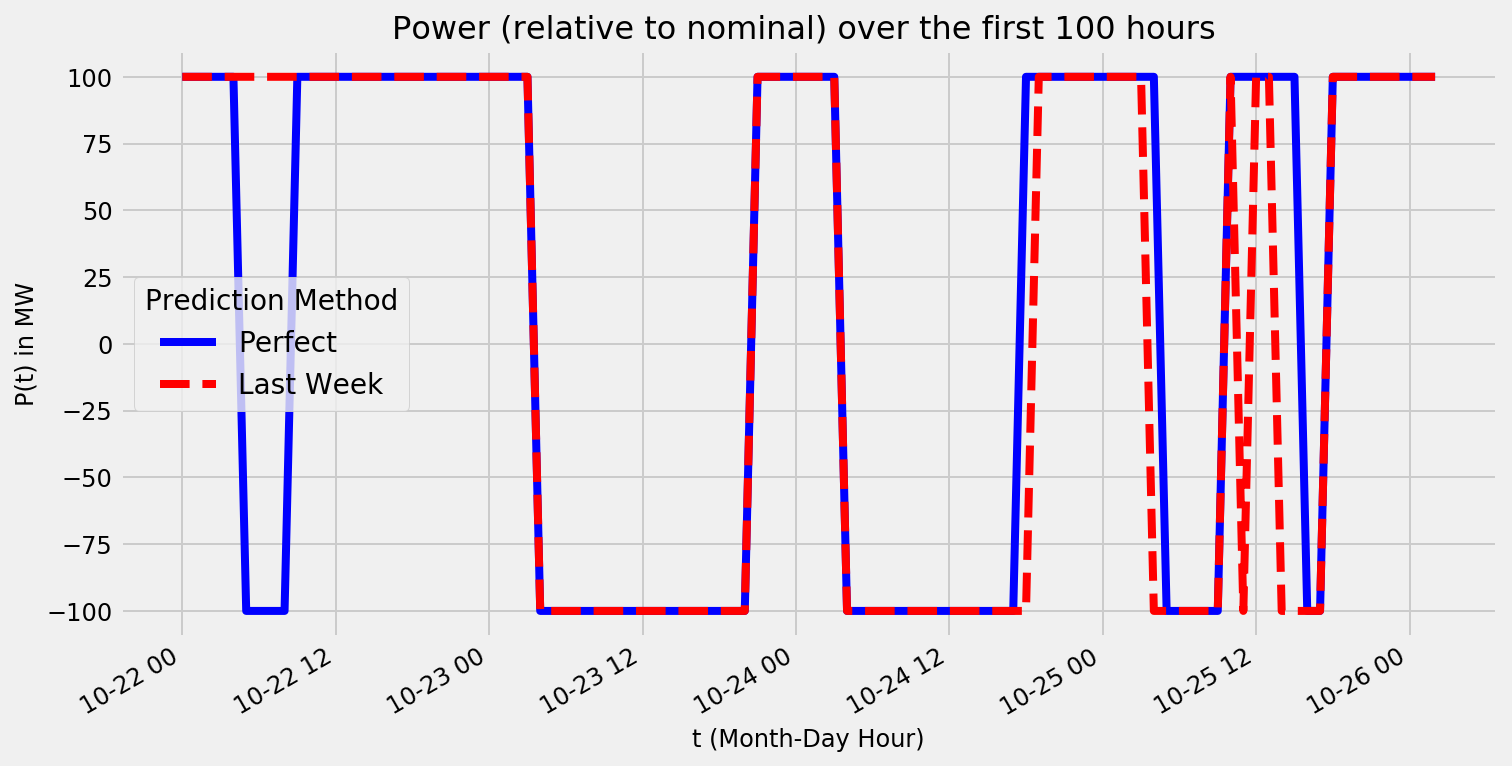

In [309]:
#Construct overall Dataframe from which to plot the solutions:
plotframe = pd.DataFrame(index = pd.date_range(t_start, t_end, freq="H"), 
                         columns = {"PerfectPower", "LastWeekPower",
                                    "PerfectEnergy", "LastWeekEnergy",
                                    "PerfectEarnings", "LastWeekEarnings"})
plotframe["PerfectPower"] = results_perfect["Power"]
plotframe["PerfectEnergy"] = results_perfect["Energy"]
plotframe["PerfectEarnings"] = results_perfect["Earnings"].cumsum()
plotframe["LastWeekPower"] = results_LastWeek["Power"]
plotframe["LastWeekEnergy"] = results_LastWeek["Energy"]
plotframe["LastWeekEarnings"] = results_LastWeek["Earnings"].cumsum()
plotframe["Price"] = results_perfect["Price"]

#Create Power Plot
powerFig, powerAx = plt.subplots(figsize = (11,6))
powerAx.set_title("Power (relative to nominal) over the first 100 hours ", fontsize = 16)
powerAx.set_xlabel("t (Month-Day Hour)", fontsize = 12)
powerAx.set_ylabel("P(t) in MW", fontsize = 12)
#Plot Data onto the axes
powerAx.plot(plotframe.iloc[0:99].index, plotframe['PerfectPower'].iloc[0:99], 'b')
powerAx.plot(plotframe.iloc[0:99].index, plotframe['LastWeekPower'].iloc[0:99], 'r', linestyle = 'dashed')
powerFig.autofmt_xdate(rotation = 30)
powerAx.tick_params(axis = 'both', labelsize = 12)
powerAx.legend(['Perfect', 'Last Week'], title = "Prediction Method")


#### Plot E(t) for the first 100 hours

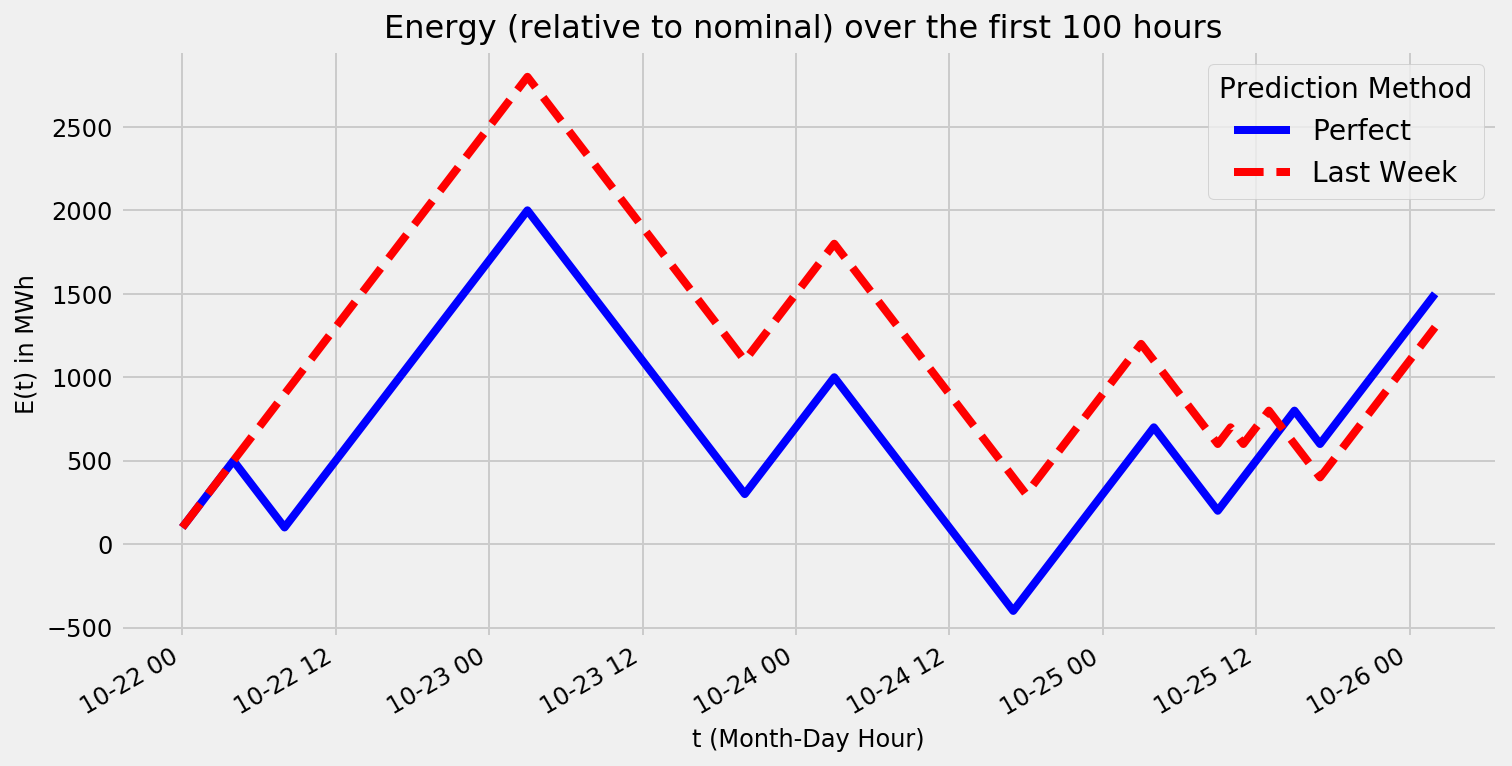

In [310]:
#Create Energy Plot
energyFig, energyAx = plt.subplots(figsize = (11,6))
energyAx.set_title("Energy (relative to nominal) over the first 100 hours ", fontsize = 16)
energyAx.set_xlabel("t (Month-Day Hour)", fontsize = 12)
energyAx.set_ylabel("E(t) in MWh", fontsize = 12)
energyAx.tick_params(axis = 'both', labelsize = 12)
#Plot Data onto the axes
energyAx.plot(plotframe.iloc[0:99].index, plotframe['PerfectEnergy'].iloc[0:99], 'b')
energyAx.plot(plotframe.iloc[0:99].index, plotframe['LastWeekEnergy'].iloc[0:99], 'r', linestyle = 'dashed')
#Fill legend
energyAx.legend(['Perfect', 'Last Week'], title = "Prediction Method")
energyFig.autofmt_xdate(rotation = 30)

#### Plot earnings

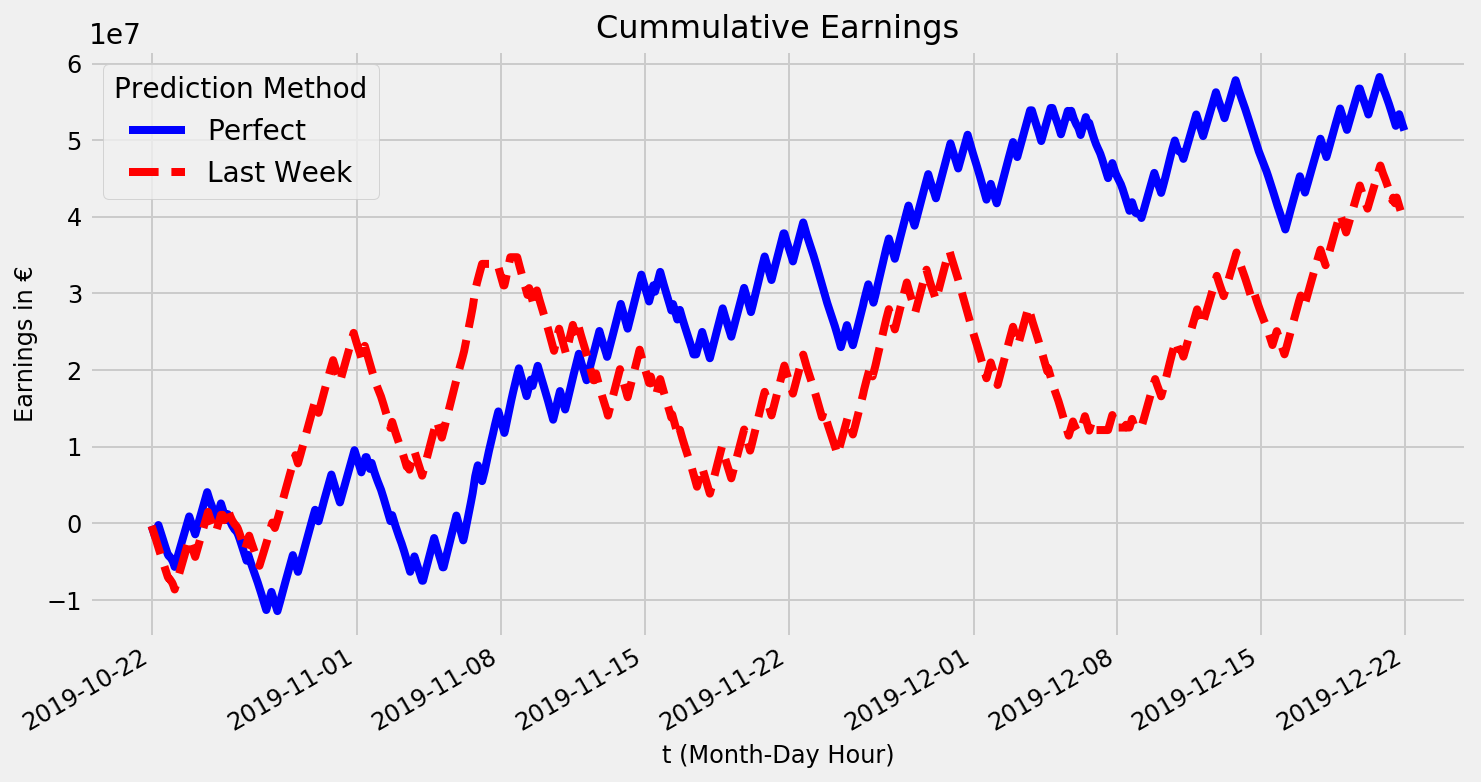

In [303]:
#Create earnings plot
earningsFig, earningsAx = plt.subplots(figsize = (11,6))
earningsAx.set_title("Cummulative Earnings", fontsize = 16)
earningsAx.set_xlabel("t (Month-Day Hour)", fontsize = 12)
earningsAx.set_ylabel("Earnings in €", fontsize = 12)
earningsAx.tick_params(axis = 'both', labelsize = 12)
#Plot Data onto the axes
earningsAx.plot(plotframe.index, plotframe['PerfectEarnings'], 'b')
earningsAx.plot(plotframe.index, plotframe['LastWeekEarnings'], 'r', linestyle = 'dashed')
#Fill legend
earningsAx.legend(['Perfect', 'Last Week'], title = "Prediction Method")
earningsFig.autofmt_xdate(rotation = 30)


#### Average Power and electricity price for each hour of the day and each day of the week  
Please note that the second y axis is inverted. This is not a data viz course, so sue me

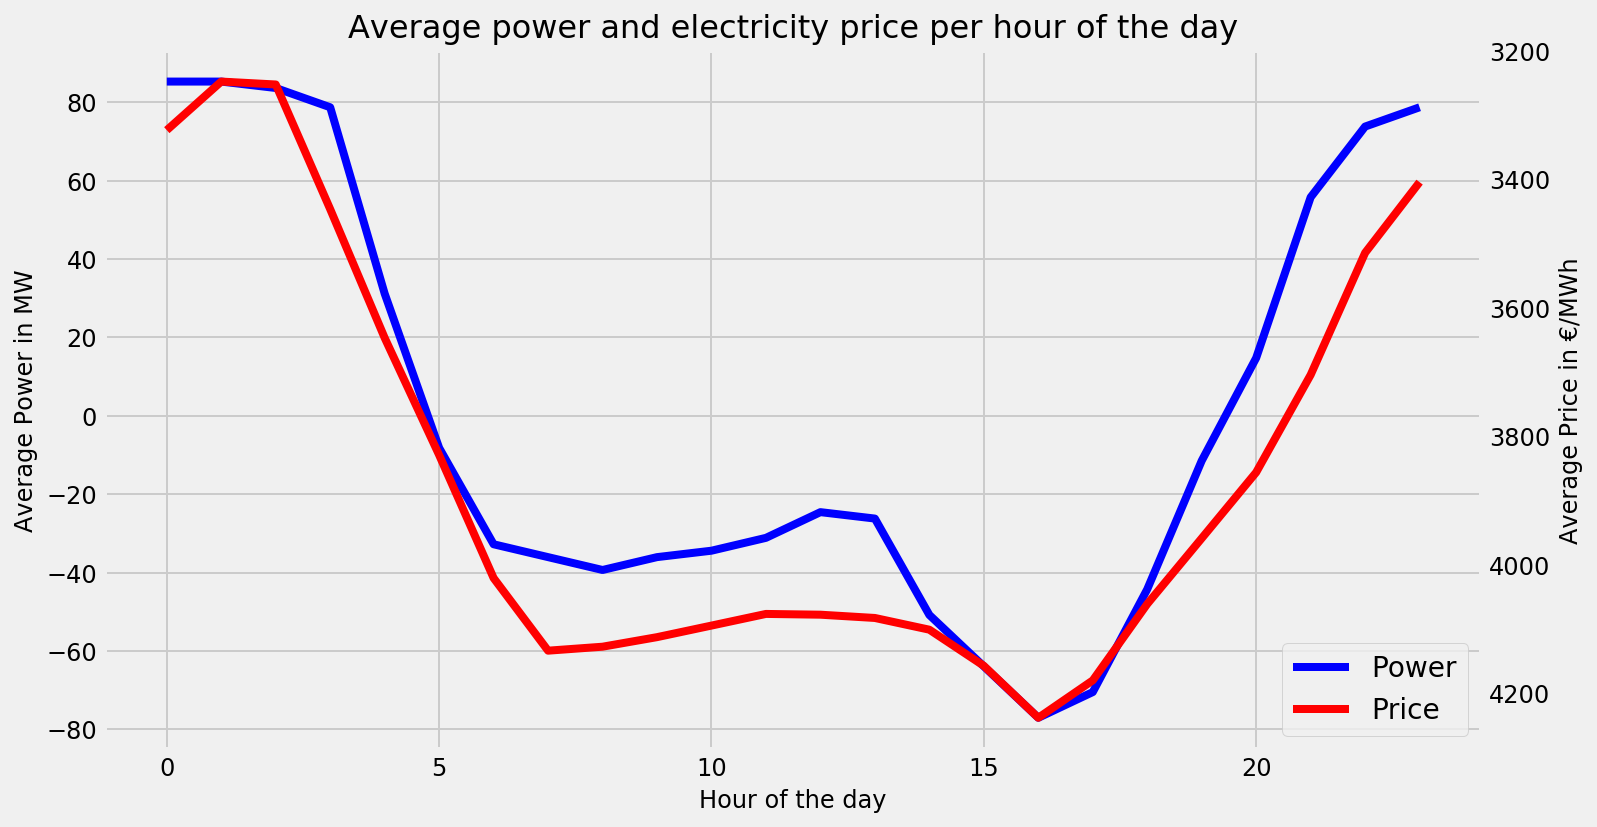

In [315]:
#calculate averages of every hours for whole dataset
series = pd.to_numeric(plotframe['LastWeekPower'])
series2 = pd.to_numeric(plotframe['Price'])
hrlyPowerAvg = series.groupby(series.index.hour).mean()
hrlyPriceAvg = series2.groupby(series2.index.hour).mean()
#create plot
hrlyFig, hrlyAx1 = plt.subplots(figsize = (11,6))
hrlyAx1.set_title("Average power and electricity price per hour of the day", fontsize = 16)
hrlyAx1.set_xlabel("Hour of the day", fontsize = 12)
hrlyAx1.set_ylabel("Average Power in MW", fontsize = 12)
hrlyAx1.tick_params(axis = 'both', labelsize = 12)
#Plot first line
lns1 = hrlyAx1.plot(hrlyPowerAvg.index, hrlyPowerAvg, 'b', label = 'Power')
#create second y-axis and plot second line
hrlyAx2 = hrlyAx1.twinx()
hrlyAx2.grid(False)
hrlyAx2.tick_params(axis = 'both', labelsize = 12)
lns2 = hrlyAx2.plot(hrlyPriceAvg.index, hrlyPriceAvg, 'r', label = 'Price')
#invert y-axis at set second y-label
hrlyAx2.invert_yaxis()
hrlyAx2.set_ylabel("Average Price in €/MWh", fontsize = 12)
#fill legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
hrlyAx1.legend(lns, labs, loc = 4)

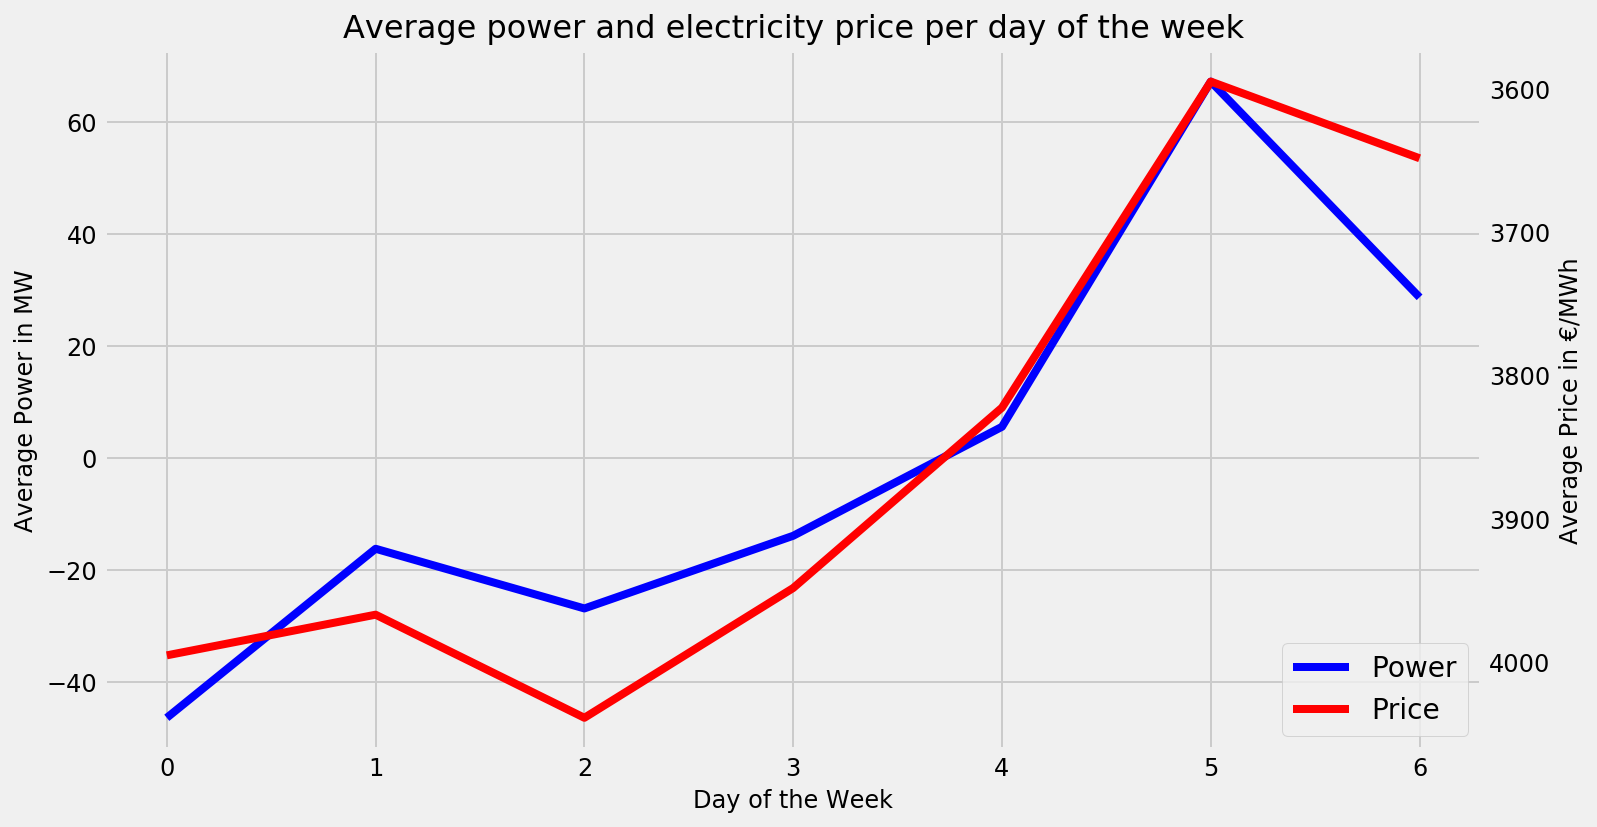

In [316]:
series = pd.to_numeric(plotframe['LastWeekPower'])
series2 = pd.to_numeric(plotframe['Price'])
wklyPowerAvg = series.groupby(series.index.weekday).mean()
wklyPriceAvg = series2.groupby(series2.index.weekday).mean()

wklyFig, wklyAx1 = plt.subplots(figsize = (11,6))
wklyAx1.set_title("Average power and electricity price per day of the week", fontsize = 16)
wklyAx1.set_xlabel("Day of the Week", fontsize = 12)
wklyAx1.set_ylabel("Average Power in MW", fontsize = 12)
wklyAx1.tick_params(axis = 'both', labelsize = 12)
#Plot first line
lns1 = wklyAx1.plot(wklyPowerAvg.index, wklyPowerAvg, 'b', label = 'Power')
#create second y-axis and plot second line
wklyAx2 = wklyAx1.twinx()
wklyAx2.grid(False)
wklyAx2.tick_params(axis = 'both', labelsize = 12)
lns2 = wklyAx2.plot(wklyPriceAvg.index, wklyPriceAvg, 'r', label = 'Price')
#invert y-axis at set second y-label
wklyAx2.invert_yaxis()
wklyAx2.set_ylabel("Average Price in €/MWh", fontsize = 12)
#fill legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
wklyAx1.legend(lns, labs, loc = 4)

#### Plot actual E(t) for the first week versus E(t) from first iteration of optimization

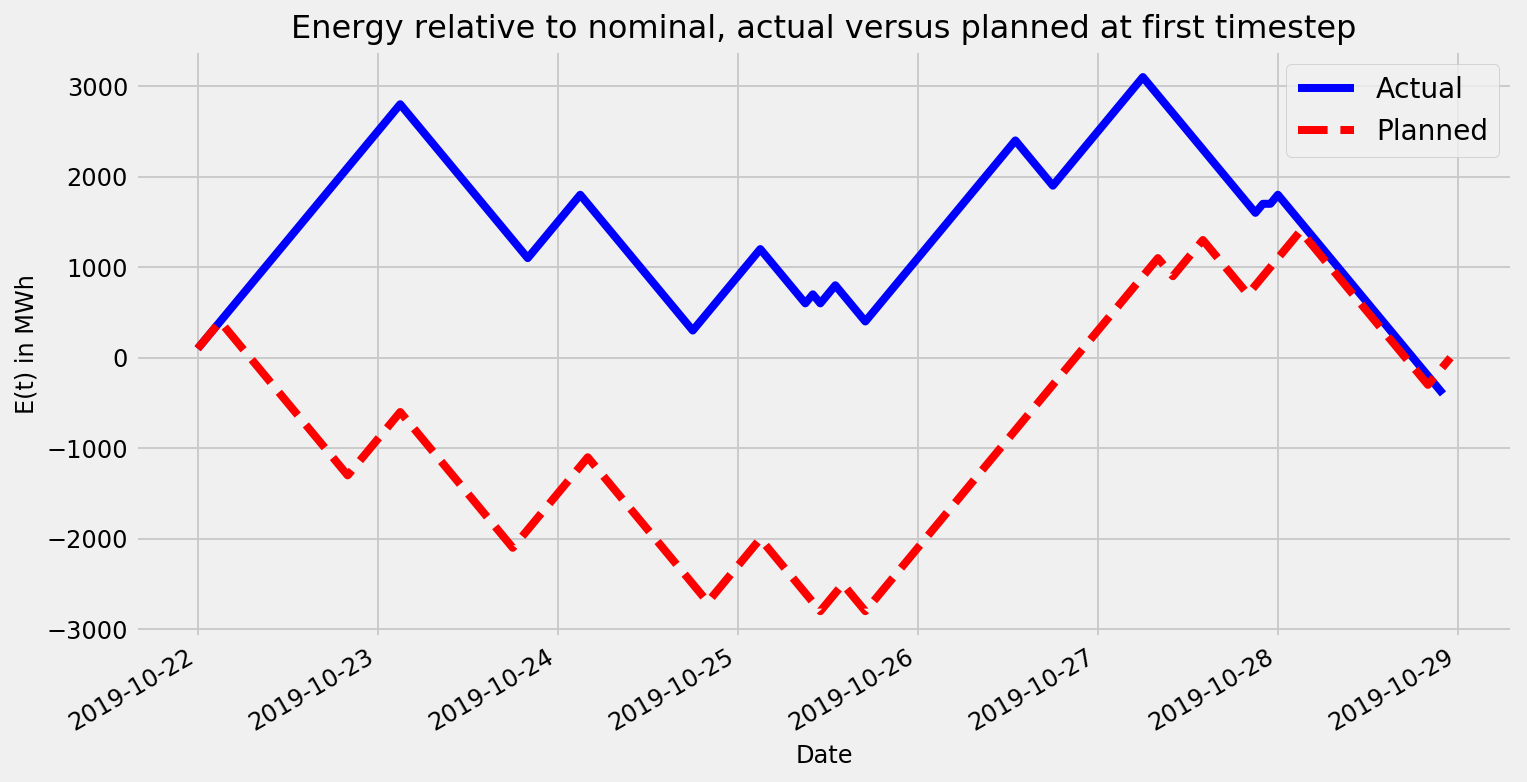

In [306]:
# retrieve solution of model for first week only
#set t_end to one week from now, so the intervall includes 7*24 datapoints
t_end_ = t_start + pd.Timedelta(7*24-1, 'h')
#Make a one time price prediction on the first day
prediction_method = "SameHourLastWeek"
predictor = PredictionGenerator(historic_prices, method=prediction_method)
predicted_prices = predictor.predict(t_start, t_horizon)
#Solve the Model initially with predicted prices for first day and given t_horizon
model, dP, dE = solve(predicted_prices, Pmax, Emax, 0, False)
#cast results into a dataframe for plotting
E = pd.DataFrame(index = pd.date_range(t_start, t_end_, freq="H"), columns = {"Planned", "Actual"})
energy = []
for i in range(len(dE)):
    energy.append(dE[i].X)
E["Planned"] = energy
E["Actual"] = plotframe["LastWeekEnergy"].iloc[0:167]

#create Axis
Fig1, Ax1 = plt.subplots(figsize = (11,6))
Ax1.set_title("Energy relative to nominal, actual versus planned at first timestep", fontsize = 16)
Ax1.set_xlabel("Date", fontsize = 12)
Ax1.set_ylabel("E(t) in MWh", fontsize = 12)
Ax1.tick_params(axis = 'both', labelsize = 12)
#Plot Data onto Axis
Ax1.plot(E.index, E["Actual"], 'b', label = 'Actual')
Ax1.plot(E.index, E["Planned"], 'r', label = 'Planned', linestyle = 'dashed')
Fig1.autofmt_xdate(rotation = 30)
Ax1.legend()
